# ALGORITMO BRANCH AND BOUND

---

Este projeto consiste na criação de um programa para resolver problemas de maximização em programação linear inteira binária. Utilizaremos o algoritmo Branch-and-Bound para encontrar a solução ótima. 

O objetivo é encontrar o valor máximo de uma função sujeita a diversas restrições, todas do tipo "menor ou igual". 

O algoritmo irá dividir o problema em subproblemas menores e, através de uma estratégia de ramificação, explorará diferentes soluções até encontrar a ótima. A Estratégia de ramificação usada será a: <br> <br>

<div style="border:2px solid black; padding: 10px; background-color:#CEE0DC">
Busca em profundidade: para isso, utilizamos uma pilha para armazenar os nós abertos (nós que ainda não foram processados)</div>

Para resolver os subproblemas, faremos uso de um pacote de programação linear, como o python-mip. 

---

In [16]:
from mip import Model, MAXIMIZE, xsum
from numpy import asarray, abs

In [17]:
def ler_txt(caminho_arquivo):
    
    """
    Lê um arquivo de texto contendo os dados de um problema de otimização e extrai as informações necessárias.

    Args:
        caminho_arquivo (str): O caminho do arquivo de texto.

    Returns:
        tuple: Uma tupla contendo o número de variáveis, o número de restrições, os coeficientes da função objetivo
        e os coeficientes das restrições do problema de otimização.
    """
        
    with open(caminho_arquivo) as arquivo:
        variaveis, restricoes = map(int, arquivo.readline().split())
        coef_obj = list(map(int, arquivo.readline().split()))

        coef_restricoes = []
        for i in range(restricoes):
            coef_restricoes.append(list(map(int, arquivo.readline().split())))

    return variaveis, restricoes, coef_obj, coef_restricoes

Exemplo teste1.txt:

\begin{gather*}
7 \quad 11\\
2 \quad 10 \quad 8 \quad 7 \quad 10 \quad 10 \quad 6\\
5 \quad 7 \quad 8 \quad 1 \quad 7 \quad 5 \quad 6 \quad 20\\
1 \quad 6 \quad 4 \quad 9 \quad 10 \quad 6 \quad 10 \quad 30\\
4 \quad 4 \quad 4 \quad 1 \quad 5 \quad 5 \quad 10 \quad 40\\
3 \quad 10 \quad 8 \quad 1 \quad 3 \quad 3 \quad 8 \quad 30\\
10 \quad 8 \quad 9 \quad 9 \quad 7 \quad 6 \quad 10 \quad 20\\
6 \quad 6 \quad 3 \quad 6 \quad 3 \quad 7 \quad 2 \quad 80\\
7 \quad 10 \quad 7 \quad 8 \quad 7 \quad 8 \quad 7 \quad 100\\
9 \quad 8 \quad 1 \quad 1 \quad 8 \quad 10 \quad 2 \quad 90\\
1 \quad 5 \quad 3 \quad 10 \quad 2 \quad 4 \quad 9 \quad 70\\
9 \quad 6 \quad 1 \quad 4 \quad 7 \quad 5 \quad 10 \quad 60\\
5 \quad 7 \quad 4 \quad 4 \quad 3 \quad 4 \quad 10 \quad 40\\
\end{gather*}


In [18]:
def podar(modelo, primal):
    """
    Verifica se um nó na árvore de busca pode ser podado com base em diferentes critérios.

    Args:
        modelo: O modelo a ser avaliado.
        primal: O valor primal atual.

    Returns:
        str: Um dos seguintes valores: 'INVIAVEL', 'INTEIRO', 'LIMITANTE' ou 'VIÁVEL'.
    """
    modelo.optimize()
    parametros = {}
    parametros["objetivo"] = modelo.objective_value
    parametros["variaveis"] = modelo.vars
    
    aux_solver = parametros
    count_int = 0

    if aux_solver["objetivo"] == None:
        return 'INVIAVEL'

    for i in aux_solver["variaveis"]:
         if round(i.x) == i.x:
            count_int += 1

    if count_int == len(aux_solver["variaveis"]):
        return 'INTEIRO'

    if aux_solver["objetivo"] <= primal:
        return 'LIMITANTE'
    
    return 'VIÁVEL'

In [19]:
def ramificar(modelo, valores_solucao):
    
    """
    Ramifica o modelo em dois novos modelos com base nos valores das variáveis de solução.

    Args:
        modelo: O modelo original a ser ramificado.
        valores_solucao (list): Uma lista de variáveis de solução.

    Returns:
        tuple: Uma tupla contendo dois modelos ramificados.
    """
    
    valores_x = [i.x for i in valores_solucao]
    idx = (abs(asarray(valores_x) - 0.5)).argmin()
    var_ramificacao = valores_solucao[idx]

    modelo_0 = modelo.copy()
    modelo_0 += var_ramificacao == 0

    modelo_1 = modelo.copy()
    modelo_1 += var_ramificacao == 1

    return modelo_0, modelo_1

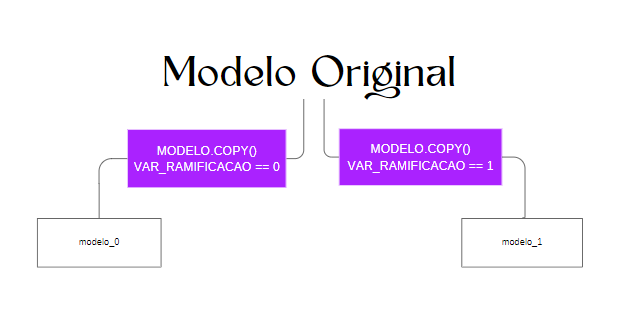

In [20]:
from IPython.display import Image

caminho_imagem = 'exemplo_ramificacao.png'
Image(filename=caminho_imagem)

In [21]:
def branch_and_bound(modelo):
    
    """
    Implementa o algoritmo de Branch and Bound para resolver o problema de otimização representado pelo modelo dado.

    Args:
        modelo: O modelo de otimização a ser resolvido.

    """
    
    global primal
    global modelo_otimo
    
    primal = 0
    modelo_otimo = None
    
    nos = [modelo]

    while nos != []:
        
        nos[0].optimize()
        parametros = {}
        parametros["objetivo"] = nos[0].objective_value
        parametros["variaveis"] = nos[0].vars
    
        modelo_solver = parametros
        
        aux = podar(nos[0], primal)
        if aux == 'INVIAVEL' or aux == 'LIMITANTE':
            nos.pop(0)
            
        elif aux == 'INTEIRO':
            if modelo_solver["objetivo"] >= primal:
                modelo_otimo = nos[0]
                primal = modelo_solver["objetivo"]
            nos.pop(0)
            
        elif aux == 'VIÁVEL':
            ramos = ramificar(nos[0], modelo_solver["variaveis"])
            nos.append(ramos[0])
            nos.append(ramos[1])
            nos.pop(0)

In [22]:
def construir_modelo(variaveis, restricoes, coef_obj, coef_restricoes):
    
    """
    Constrói um modelo de otimização linear com base nos parâmetros fornecidos.

    Args:
        variaveis (int): O número de variáveis do modelo.
        restricoes (int): O número de restrições do modelo.
        coef_obj (list): Os coeficientes da função objetivo.
        coef_restricoes (list): Os coeficientes das restrições.

    Returns:
        modelo: O modelo de otimização construído.
    """
    
    modelo = Model(sense=MAXIMIZE)

    x = [modelo.add_var(var_type="CONTINUOUS", lb=0, ub=1, name="X." + str(i+1)) for i in range(variaveis)]

    modelo.objective = xsum(coef_obj[i] * x[i] for i in range(variaveis))

    for i in range(restricoes):
        modelo += xsum(coef_restricoes[i][j] * x[j] for j in range(variaveis)) <= coef_restricoes[i][-1]
        
    return  modelo   

In [23]:
def executar(arquivo):
    
    """
    Executa o algoritmo de Branch and Bound para resolver o problema de otimização especificado no arquivo de entrada.

    Args:
        arquivo (str): O caminho do arquivo de entrada contendo os dados do problema.

    """
        
    variaveis, restricoes, coef_obj, coef_restricoes = ler_txt(arquivo)

    modelo = construir_modelo(variaveis, restricoes, coef_obj, coef_restricoes)

    branch_and_bound(modelo)
        
    modelo_otimo.optimize()
    modelo_resolvido = {}
    modelo_resolvido["objetivo"] = modelo_otimo.objective_value
    modelo_resolvido["variaveis"] = modelo_otimo.vars   
    
    print("Modelo:")
    modelo.write("modelo.lp") # salva modelo em arquivo
    with open("modelo.lp", "r") as f: # lê e exibe conteúdo do arquivo
        print(f.read())
    print("\nResultado:")
    print("Variáveis:")
    
    for i in modelo_resolvido["variaveis"]:
        print(i.name, ' = ', i.x)
    print("Função objetivo:")
    print('Z = ', modelo_resolvido["objetivo"])

# Aplicação nos teste.txt

In [24]:
executar("teste1.txt")

Modelo:
\Problem name: 

Minimize
OBJROW: -2 X.1 -10 X.2 -8 X.3 -7 X.4 -10 X.5 -10 X.6 -6 X.7
Subject To
constr(0):  5 X.1 + 7 X.2 + 8 X.3 + X.4 + 7 X.5 + 5 X.6 + 6 X.7 <= 20
constr(1):  X.1 + 6 X.2 + 4 X.3 + 9 X.4 + 10 X.5 + 6 X.6 + 10 X.7 <= 30
constr(2):  4 X.1 + 4 X.2 + 4 X.3 + X.4 + 5 X.5 + 5 X.6 + 10 X.7 <= 40
constr(3):  3 X.1 + 10 X.2 + 8 X.3 + X.4 + 3 X.5 + 3 X.6 + 8 X.7 <= 30
constr(4):  10 X.1 + 8 X.2 + 9 X.3 + 9 X.4 + 7 X.5 + 6 X.6 + 10 X.7 <= 20
constr(5):  6 X.1 + 6 X.2 + 3 X.3 + 6 X.4 + 3 X.5 + 7 X.6 + 2 X.7 <= 80
constr(6):  7 X.1 + 10 X.2 + 7 X.3 + 8 X.4 + 7 X.5 + 8 X.6 + 7 X.7 <= 100
constr(7):  9 X.1 + 8 X.2 + X.3 + X.4 + 8 X.5 + 10 X.6 + 2 X.7 <= 90
constr(8):  X.1 + 5 X.2 + 3 X.3 + 10 X.4 + 2 X.5 + 4 X.6 + 9 X.7 <= 70
constr(9):  9 X.1 + 6 X.2 + X.3 + 4 X.4 + 7 X.5 + 5 X.6 + 10 X.7 <= 60
constr(10):  5 X.1 + 7 X.2 + 4 X.3 + 4 X.4 + 3 X.5 + 4 X.6 + 10 X.7 <= 40
Bounds
 0 <= X.1 <= 1
 0 <= X.2 <= 1
 0 <= X.3 <= 1
 0 <= X.4 <= 1
 0 <= X.5 <= 1
 0 <= X.6 <= 1
 0 <= X.7

In [25]:
executar("teste2.txt")

Modelo:
\Problem name: 

Minimize
OBJROW: -7 X.1 -7 X.2 -7 X.3 -5 X.4 -8 X.5 -8 X.6 -9 X.7 -10 X.8 -7 X.9
Subject To
constr(0):  X.1 + 3 X.2 + X.3 + 3 X.4 + 3 X.5 + 7 X.6 + 2 X.7 + X.8 + 4 X.9 <= 80
constr(1):  7 X.1 + 6 X.2 + 10 X.3 + X.4 + 7 X.5 + 2 X.6 + 2 X.7 + 7 X.8 + X.9 <= 90
constr(2):  3 X.1 + 2 X.2 + X.3 + 3 X.4 + 3 X.5 + 2 X.6 + X.7 + 6 X.8 + 5 X.9 <= 10
constr(3):  10 X.1 + 8 X.2 + 3 X.3 + 6 X.4 + 10 X.5 + 7 X.6 + 3 X.7 + 10 X.8 + 4 X.9 <= 30
constr(4):  2 X.1 + 8 X.2 + 6 X.3 + 5 X.4 + 6 X.5 + 6 X.6 + 9 X.7 + 7 X.8 + 2 X.9 <= 80
constr(5):  3 X.1 + 10 X.2 + X.3 + 9 X.4 + 2 X.5 + 7 X.6 + 7 X.7 + 9 X.8 + 10 X.9 <= 90
constr(6):  X.1 + 7 X.2 + 10 X.3 + 10 X.4 + 5 X.5 + 2 X.6 + 9 X.7 + 10 X.8 + 2 X.9 <= 20
constr(7):  10 X.1 + 3 X.2 + 2 X.3 + 3 X.4 + 10 X.5 + 2 X.6 + X.7 + 9 X.8 + 7 X.9 <= 10
constr(8):  2 X.1 + X.2 + 7 X.3 + 10 X.4 + X.5 + X.6 + 2 X.7 + X.8 + X.9 <= 50
Bounds
 0 <= X.1 <= 1
 0 <= X.2 <= 1
 0 <= X.3 <= 1
 0 <= X.4 <= 1
 0 <= X.5 <= 1
 0 <= X.6 <= 1
 0 <= X.7 <=

In [26]:
executar("teste3.txt")

Modelo:
\Problem name: 

Minimize
OBJROW: -7 X.1 -9 X.2 -10 X.3 -3 X.4 -6 X.5 - X.6 -9 X.7 -8 X.8 -8 X.9
Subject To
constr(0):  2 X.1 + X.2 + 9 X.3 + 6 X.4 + 3 X.5 + 6 X.6 + 10 X.7 + 9 X.8 + X.9 <= 60
constr(1):  8 X.1 + 6 X.2 + 6 X.3 + 5 X.4 + 2 X.5 + 2 X.6 + 4 X.7 + 3 X.8 + 6 X.9 <= 80
constr(2):  8 X.1 + X.2 + 3 X.3 + 7 X.4 + X.5 + 4 X.6 + 8 X.7 + 3 X.8 + 4 X.9 <= 30
constr(3):  6 X.1 + 3 X.2 + 9 X.3 + 5 X.4 + 9 X.5 + 6 X.6 + 9 X.7 + 9 X.8 + 6 X.9 <= 40
constr(4):  10 X.1 + 8 X.2 + 8 X.3 + 7 X.4 + 10 X.5 + 10 X.6 + 9 X.7 + 9 X.8 + 3 X.9 <= 20
constr(5):  10 X.1 + 10 X.2 + 10 X.3 + 9 X.4 + 10 X.5 + X.6 + 8 X.7 + 3 X.8 + 10 X.9 <= 90
constr(6):  10 X.1 + 5 X.2 + 8 X.3 + 2 X.4 + 7 X.5 + 8 X.6 + 6 X.7 + 2 X.8 + 2 X.9 <= 90
constr(7):  7 X.1 + 9 X.2 + X.3 + 9 X.4 + 5 X.5 + 8 X.6 + 5 X.7 + 9 X.8 + 5 X.9 <= 80
constr(8):  2 X.1 + 4 X.2 + 6 X.3 + X.4 + 7 X.5 + 9 X.6 + 10 X.7 + X.8 + 7 X.9 <= 80
constr(9):  8 X.1 + 10 X.2 + 2 X.3 + 6 X.4 + 7 X.5 + 2 X.6 + 2 X.7 + 4 X.8 + 9 X.9 <= 10
constr(1

In [27]:
executar("teste4.txt")

Modelo:
\Problem name: 

Minimize
OBJROW: -9 X.1 -7 X.2 -10 X.3 -7 X.4 -9 X.5 -6 X.6 -8 X.7 -4 X.8 -9 X.9
Subject To
constr(0):  4 X.1 + 9 X.2 + 4 X.3 + X.4 + 9 X.5 + 6 X.6 + 3 X.7 + 6 X.8 + X.9 <= 40
constr(1):  3 X.1 + 7 X.2 + 8 X.3 + 7 X.4 + 6 X.5 + 3 X.6 + 5 X.7 + 9 X.8 + 4 X.9 <= 80
constr(2):  9 X.1 + 3 X.2 + 6 X.3 + 5 X.4 + 7 X.5 + X.6 + X.7 + 3 X.8 + 9 X.9 <= 40
constr(3):  5 X.1 + 9 X.2 + 6 X.3 + 5 X.4 + 9 X.5 + 7 X.6 + 8 X.7 + 7 X.8 + 8 X.9 <= 10
constr(4):  7 X.1 + 7 X.2 + 4 X.3 + X.4 + 3 X.5 + 4 X.6 + 8 X.7 + X.8 + 9 X.9 <= 10
constr(5):  X.1 + 6 X.2 + 6 X.3 + X.4 + 6 X.5 + 7 X.6 + 3 X.7 + 8 X.8 + 7 X.9 <= 10
constr(6):  6 X.1 + 6 X.2 + 8 X.3 + 6 X.4 + 10 X.5 + 8 X.6 + X.7 + 4 X.8 + 4 X.9 <= 70
constr(7):  9 X.1 + X.2 + 9 X.3 + 7 X.4 + 10 X.5 + 5 X.6 + 6 X.7 + 2 X.8 + 5 X.9 <= 10
constr(8):  2 X.1 + 7 X.2 + 6 X.3 + 5 X.4 + X.5 + X.6 + 9 X.7 + 2 X.8 + X.9 <= 20
Bounds
 0 <= X.1 <= 1
 0 <= X.2 <= 1
 0 <= X.3 <= 1
 0 <= X.4 <= 1
 0 <= X.5 <= 1
 0 <= X.6 <= 1
 0 <= X.7 <= 1
 0 